In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Cluster import Butina
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

In [2]:
LigandDescriptors = ['HeavyAtomCount','NHOHCount','NOCount']
DescCalc = MolecularDescriptorCalculator(LigandDescriptors)
len(LigandDescriptors)

3

In [3]:
def GetRDKitDescriptors(smile):
    '''Function for the calculation of ligand descriptors'''
    mol = Chem.MolFromSmiles(smile)
    mol.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(mol)
    return DescCalc.CalcDescriptors(mol)

def Update_descriptor(df):
    Features = []
    for i in df.canonical_smiles.tolist():
        Features.append(GetRDKitDescriptors(i))
    ss = pd.DataFrame(Features, columns=LigandDescriptors)
    df = pd.concat([df,ss], axis=1, ignore_index=False)
    df['pValue'] = 6 - np.log10(df['acvalue'])
    df['LE'] = df['pValue']/df['HeavyAtomCount']
    return df

### Combine all active compounds collected from PubChem
#### (based on GeneID of CAMK2a, 2b, 2g and 2d)
These .csv files are directly downloaded from PubChem

In [4]:
camk2a = pd.read_csv('dataset/dataset_PubChem/GeneID_815_bioactivity_gene_CAMK2a.csv')
camk2b = pd.read_csv('dataset/dataset_PubChem/GeneID_816_bioactivity_gene_CAMK2b.csv')
camk2g = pd.read_csv('dataset/dataset_PubChem/GeneID_818_bioactivity_gene_CAMK2g.csv')
camk2d = pd.read_csv('dataset/dataset_PubChem/GeneID_817_bioactivity_gene_CAMK2d.csv')
df = pd.concat([camk2a,camk2b,camk2g,camk2d], ignore_index=True)
df.head(2)

/home/cyang/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (11,12,13,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,baid,activity,aid,sid,cid,geneid,pmid,aidtype,aidmdate,hasdrc,...,aidsrcname,aidname,cmpdname,targetname,targeturl,ecs,repacxn,taxids,cellids,targettaxid
0,39913920,Active,1433,50100117,10138259,815,NaN,Other,20170124,0,...,Ambit Biosciences,Kinase Inhibitor Selectivity Profiling Assay,"1H-Pyrrole-3-carboxamide, 5-((5-fluoro-1,2-dih...",CAMK2A - calcium/calmodulin dependent protein ...,/gene/815,2.7.11.17,Q9UQM7,NaN,NaN,NaN
1,39914188,Active,1433,50100117,10138259,815,NaN,Other,20170124,0,...,Ambit Biosciences,Kinase Inhibitor Selectivity Profiling Assay,"1H-Pyrrole-3-carboxamide, 5-((5-fluoro-1,2-dih...",CAMK2A - calcium/calmodulin dependent protein ...,/gene/815,2.7.11.17,Q9UQM7,NaN,NaN,NaN


#### Select activity with Kd, IC50 or Ki data avaliable.
#### Remove duplicates, and select compounds with pValue >=6 (acvalue<=1) and LE >= 0.28.

In [5]:
df1 = df.loc[(df['activity']=='Active')&(df['acname'].isin(['Kd','IC50','Ki']))]
df1 = df1.sort_values(by=['acvalue','cid'], ascending=[True,False])
df1 = df1.drop_duplicates('cid')
df1 = df1[['cid','activity','acname','acvalue']]
df1 = df1.loc[df1['acvalue']<=1]
len(df1)

178

This pubchempy module is used to obtain smiles of compounds based on cid.

In [6]:
import pubchempy as pcp

In [7]:
df1['canonical_smiles'] = df1['cid'].map(lambda x:pcp.Compound.from_cid(x).canonical_smiles)

In [8]:
df1 = df1.reset_index(drop=True)
df1.head(2)

,cid,activity,acname,acvalue,canonical_smiles
0,451705,Active,Kd,0.000024,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...
1,44259,Active,IC50,0.000031,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...


In [9]:
df1 = Update_descriptor(df1)

In [10]:
df1 = df1.loc[(df1['pValue']>=6)&(df1['LE']>=0.28)]
df1 = df1.sort_values(by='pValue', ascending=False)
len(df1)

26

### Show compounds

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [15]:
mols = []
Name = []

for i,j,k in zip(df1['canonical_smiles'], df1['cid'], df1['pValue']):
    mol = Chem.MolFromSmiles(i)
    mols.append(mol)
    Name.append('cid%s | pValue=%.2f'%(j,k))

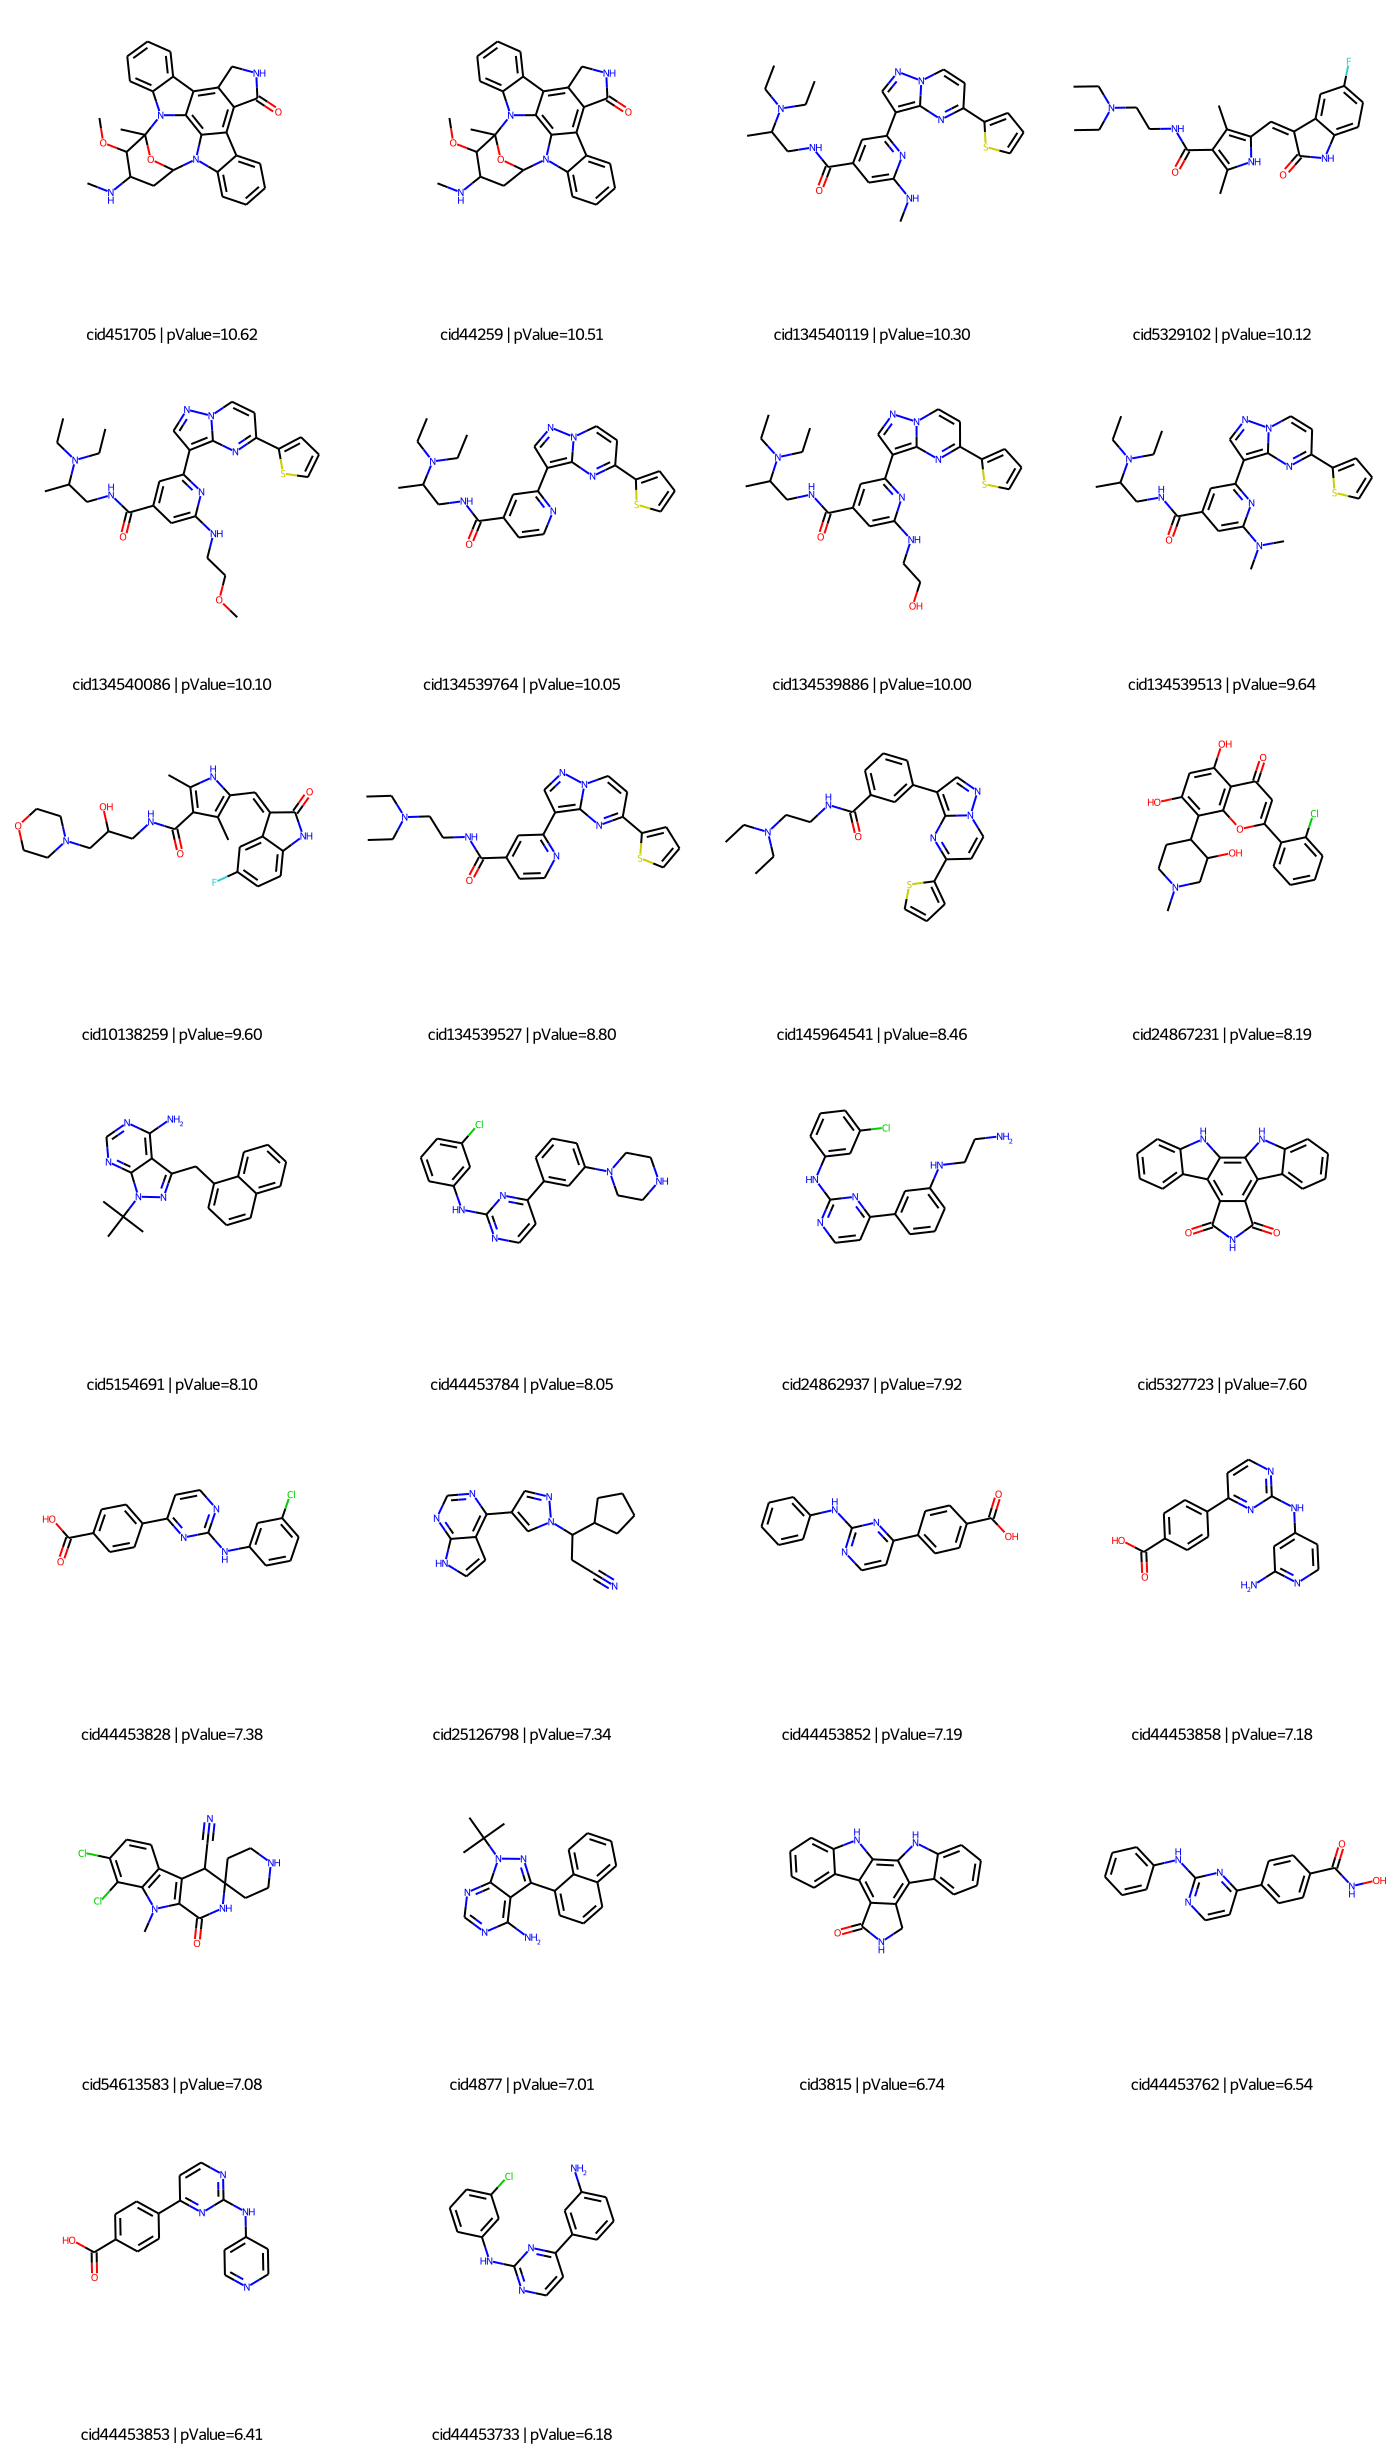

In [16]:
Chem.Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(350, 350),legends=Name)

In [14]:
df1.to_csv('dataset/curated_binders/binders_from_PubChem.csv', index=False)